In [27]:
from dataclasses import dataclass
from typing import Literal, Optional
import graphviz as gv

# 各阶段耗时

In [28]:
def division_ceil(a: int, b: int) -> int:
    return (a + b - 1) // b

# 一个待优化的批MSM问题
@dataclass
class Instance:
    # 域元素位宽
    lambd: int
    # PCIE速率，单位byte/ms
    v: int
    # 点索引字节数
    delta: int
    # 点数为2**k
    k: int
    # MSM批大小，这些MSM共用相同一组点
    n: int
    # 显存大小
    g: int

    def scaler_size(self) -> int:
        return division_ceil(self.lambd, 8)

    def point_affine_size(self) -> int:
        return self.scaler_size() * 2

    def point_xyzz_size(self) -> int:
        return self.scaler_size() * 4

# 待优化的参数
@dataclass
class Parameters:
    # 窗口位宽
    s: int
    # 预计算系数：每alpha个窗口预计算一组点
    alpha: int
    # 子MSM宽度
    w: int
    # 子MSM高度
    h: int
    # 子MSM段宽度
    c: int

    def n_weights(self) -> int:
        return 2 ** self.s

# 实现相关的参数，需要估计
@dataclass
class Estimations:
    # Scatter阶段的时间系数
    r_scatter: float
    # Buckets-Sum阶段的时间系数
    r_buckets_sum1: float
    r_buckets_sum2: float
    # Buckets-Reduction阶段的时间系数
    r_buckets_reduction: float

def n_total_windows(i: Instance, p: Parameters) -> int:
    return division_ceil(i.lambd, p.s)

def workload_scatter(i: Instance, p: Parameters) -> int:
    return p.c * n_total_windows(i, p)

def workload_buckets_sum1(i: Instance, p: Parameters) -> int:
    return p.c * n_total_windows(i, p)

def workload_buckets_sum2(i: Instance, p: Parameters) -> int:
    return p.n_weights() * n_total_windows(i, p)

def workload_buckets_reduction(i: Instance, p: Parameters) -> int:
    return p.n_weights() * p.alpha * p.h * 2

@dataclass
class Model:
    i: Instance
    p: Parameters
    e: Estimations
    
    def s_points(self) -> int:
        """预计算之后的一段点所需空间，单位字节"""
        return division_ceil(self.i.lambd, self.p.s * self.p.alpha) * self.p.c * self.i.point_affine_size()
    
    def t_points(self) -> float:
        return self.s_points() / self.i.v
    
    def s_scalers(self) -> int:
        """一段标量所需空间，单位字节"""
        return self.p.c * self.i.scaler_size()
    
    def t_scalers(self) -> int:
        return self.s_scalers() / self.i.v

    def s_points_chunk(self) -> int:
        return division_ceil(self.s_points(), self.p.h)

    def t_points_chunk(self) -> float:
        return self.t_points() / self.p.h
    
    def t_scatter(self) -> float:
        """Scatter阶段所需时间，单位毫秒"""
        return self.e.r_scatter * workload_scatter(self.i, self.p)
    
    def s_indices(self) -> int:
        """Scatter之后产生的点索引所需空间，单位字节"""
        return 2 * self.p.c * n_total_windows(self.i, self.p) * self.i.delta

    def t_buckets_sum(self) -> float:
        """Buckets-Sum阶段所需时间，单位毫秒"""
        return self.e.r_buckets_sum1 * workload_buckets_sum1(self.i, self.p) + self.e.r_buckets_sum2 * workload_buckets_sum2(self.i, self.p)

    def s_buckets(self) -> int:
        """Buckets-Sum之后产生的桶所需空间，单位字节"""
        return self.p.n_weights() * self.p.alpha * self.i.point_xyzz_size()

    def t_buckets_reduction(self) -> float:
        """Buckets-Reduction所需时间，单位毫秒"""
        return self.e.r_buckets_reduction * workload_buckets_reduction(self.i, self.p)

@dataclass
class Sample:
    i: Instance
    p: Parameters
    t_scatter: float
    t_buckets_sum: float
    t_buckets_reduction: float

def least_square(xs: list[float], ys: list[float], zs: list[float]):
    X2 = sum((x * x for x in xs))
    Y2 = sum((y * y for y in ys))
    XY = sum((x * y for x, y in zip(xs, ys)))
    XZ = sum((x * z for x, z in zip(xs, zs)))
    YZ = sum((y * z for y, z in zip(ys, zs)))
    delta = X2 * Y2 - 2 * XY
    if abs(delta) < 1e-6:
        raise RuntimeError("Error solving least square: determinant is too small")
    a = (Y2 * XZ - XY * YZ) / delta
    b = (-XY * XZ + X2 * YZ) / delta
    return a, b

def fit_model(samples: list[Sample]) -> Estimations:
    n_samples = len(samples)

    r_scatter = sum((sp.t_scatter / workload_scatter(sp.i, sp.p) for sp in samples)) / n_samples
    r_buckets_reduction = sum((sp.t_buckets_reduction / workload_buckets_reduction(sp.i, sp.p) for sp in samples)) / n_samples
    r_buckets_sum1, r_buckets_sum2 = least_square(
        [workload_buckets_sum1(sp.i, sp.p) for sp in samples],
        [workload_buckets_sum2(sp.i, sp.p) for sp in samples],
        [sp.t_buckets_sum for sp in samples]
    )

    return Estimations(r_scatter, r_buckets_sum1, r_buckets_sum2, r_buckets_reduction)
        

## 计算图

In [29]:
@dataclass
class Task:
    track: Literal['pcie', 'compute']
    name: str
    duration: float
    space: int
    depends_on: list['Task']
    depended_by: list['Task']
    data_depends_on: list['Task']
    data_depended_by: list['Task']
    replaces_space: Optional['Task']
    replaced_space_by: Optional['Task']
    
    @staticmethod
    def new(track: Literal['pcie', 'compute'], name: str, duration: float, space: int=0) -> 'Task':
        return Task(track, name, duration, space, [], [], [], [], None, None)

    def add_data_depend(self, task: 'Task', inplace: bool = False):
        self.depends_on.append(task)
        task.depended_by.append(self)
        self.data_depends_on.append(task)
        task.data_depended_by.append(self)
        if inplace:
            assert task.replaced_space_by is None
            assert len(task.data_depended_by) == 1
            task.replaced_space_by = self
            self.replaces_space = task

    def remove_depend(self, task: 'Task'):
        self.depends_on[:] = [t for t in self.depends_on if t is not task]
        task.depended_by[:] = [t for t in task.depended_by if t is not self]
        self.data_depends_on[:] = [t for t in self.data_depends_on if t is not task]
        task.data_depended_by[:] = [t for t in task.data_depended_by if t is not self]

    def add_sequence(self, task: 'Task'):
        self.depends_on.append(task)
        task.depended_by.append(self)

    def add_sequence_dead(self, task: 'Task'):
        for child in task.data_depended_by:
            if child is not self:
                self.add_sequence(child)

    def __hash__(self) -> int:
        return id(self)

    def __eq__(self, rhs: object) -> bool:
        return id(self) == id(rhs)

    def format(self, delim: str) -> str:
        s = "Task(" + delim
        s += f"  track={self.track}," + delim
        s += f"  name={self.name}," + delim
        s += f"  duration={self.duration}," + delim
        s += f"  depends_on={[x.name for x in self.depends_on]}," + delim
        s += f"  depended_by={[x.name for x in self.depended_by]}" + delim
        s += ")"
        return s
    
    def __str__(self) -> str:
        return self.format('\n')

    def __repr__(self) -> str:
        return self.format(' ')

In [30]:
def build_block_computation_graph(m: Model) -> list[Task]:
    segments = [
        [
            dict(
                scalers=Task.new('pcie', f'Scalers {i_col}.{i_row}', m.t_scalers(), m.s_scalers()),
                scatter=Task.new('compute', f'Scatter {i_col}.{i_row}', m.t_scatter(), m.s_indices()),
                buckets_sum=Task.new('compute', f'Buckets Sum {i_col}.{i_row}', m.t_buckets_sum(), m.s_buckets())
            )
            for i_row in range(m.p.h)
        ]
        for i_col in range(m.p.w)
    ]
    points = [Task.new('pcie', f'Points {i_col}', 0.0, m.s_points()) for i_col in range(m.p.w)]
    point_chunks = [[Task.new('pcie', f'Points {i_col}.{i_row}', m.t_points_chunk(), m.s_points_chunk()) for i_row in range(m.p.h)] for i_col in range(m.p.w)]
    reductions = [Task.new('compute', f'Buckets Reduction {i_row}', m.t_buckets_reduction()) for i_row in range(m.p.h)]

    # Basic dependencies

    for col in segments:
        for segment in col:
            segment['scatter'].add_data_depend(segment['scalers'])
            segment['buckets_sum'].add_data_depend(segment['scatter'])

    for i_row in range(len(segments[0])):
        for i_col in range(len(segments) - 1):
            segments[i_col + 1][i_row]['buckets_sum'].add_data_depend(segments[i_col][i_row]['buckets_sum'], inplace=True)
        reductions[i_row].add_data_depend(segments[len(segments) - 1][i_row]['buckets_sum'])

    for i_col in range(len(points)):
        for point_chunk in point_chunks[i_col]:
            points[i_col].add_data_depend(point_chunk)

    for col, point in zip(segments, points):
        for segment in col:
            segment['buckets_sum'].add_data_depend(point)

    # Sequencing

    i_last_row = len(segments[0]) - 1
    i_last_col = len(segments) - 1

    for i_col in range(len(segments)):
        points[i_col].add_sequence(segments[i_col][0]['scalers'])
        for i_row in range(len(segments[0]) - 1):
            segments[i_col][i_row + 1]['scatter'].add_sequence(segments[i_col][i_row]['buckets_sum'])
        if i_col < len(segments) - 1:
            segments[i_col + 1][0]['scatter'].add_sequence(segments[i_col][i_last_row]['buckets_sum'])
    reductions[0].add_sequence(segments[i_last_col][i_last_row]['buckets_sum'])

    for i_row in range(len(reductions) - 1):
        reductions[i_row + 1].add_sequence(reductions[i_row])

    scalers_flat = [segments[i // m.p.h][i % m.p.h]['scalers'] for i in range(m.p.w * m.p.h)]
    point_chunks_flat = [point_chunks[i // m.p.h][i % m.p.h] for i in range(m.p.w * m.p.h)]
    point_chunks[0][0].add_sequence(segments[0][0]['scalers'])
    for i_row in range(i_last_row):
        point_chunks[0][i_row + 1].add_sequence(point_chunks[0][i_row])
    for i in range(1, 1 + i_last_col * m.p.h):
        scalers_flat[i].add_sequence(point_chunks_flat[i + m.p.h - 2])
        point_chunks_flat[i + m.p.h - 1].add_sequence(scalers_flat[i])

    # Live range avoidance

    for i_col in range(len(segments)):
        for i_row in range(len(segments[0]) - 1):
            segments[i_col][i_row + 1]['scalers'].add_sequence_dead(segments[i_col][i_row]['scalers'])
        if i_col < len(segments) - 1:
            segments[i_col + 1][0]['scalers'].add_sequence_dead(segments[i_col][i_last_row]['scalers'])

    return [segments[0][0]['scalers']]

### 绘制计算图

In [31]:
def gv_of_computation_graph(ready: list[Task]) -> gv.Digraph:
    def shape(t: Task) -> str:
        if t.track == 'pcie':
            return 'ellipse'
        elif t.track == 'compute':
            return 'rectangle'

    visited: set(Task) = set()
    g = gv.Digraph('Cg')
    g.graph_attr['rankdir'] = 'LR' 
    
    def f(root: Task):
        g.node(root.name, shape=shape(root))
        visited.add(root)

        for child in root.depended_by:
            if child in root.data_depended_by:
                g.edge(root.name, child.name)
            else:
                g.edge(root.name, child.name, style='dashed')
            if child not in visited:
                f(child)

    for root in ready:
        f(root)

    return g

## 甘特图

### 模拟调度器

In [32]:
@dataclass
class TrackEvent:
    begin: float
    task: Task

    def __hash__(self) -> int:
        return id(self.task)

    def __eq__(self, rhs: object) -> bool:
        return id(self.task) == id(rhs.task)

    def end(self) -> float:
        return self.begin + self.task.duration

Simulation = dict[str, list[TrackEvent]]

def simulate_computation_graph(ready: list[Task], log: bool=False) -> Simulation:
    r = dict(pcie=[], compute=[])
    running = dict(pcie=None, compute=None)
    degrees_in = dict()

    def decrement_degree_in(task: Task):
        if task in degrees_in:
            degrees_in[task] -= 1
        else:
            degrees_in[task] = len(task.depends_on) - 1
        assert degrees_in[task] >= 0
        return degrees_in[task]

    t = 0.0

    def running_empty():
        return all((x == None for x in running.values()))

    while len(ready) != 0 or not running_empty():
        if log:
            print(f"[t = {t}]Ready list is {[x.name for x in ready]}")
        
        # Look for tasks in `ready` that can be run and move them to `running`
        updated_ready = []
        for task in ready:
            if running[task.track] is None:
                running[task.track] = (task, t + task.duration)
                r[task.track].append(TrackEvent(t, task))
            else:
                updated_ready.append(task)
        ready = updated_ready

        if log:
            print(f"[t = {t}]Updated Ready list is {[x.name for x in ready]}")
            print(f"[t = {t}]Running list is {[(x[0], x[1][0].name, x[1][1]) for x in running.items() if x[1] is not None]}")


        # Fast forward so that some task finishes running
        next_finish_track_name, next_finish_task, t = min(
            (
                (track_name, track[0], track[1])
                for track_name, track in running.items() if track is not None
            ),
            key=lambda x: x[2]
        )

        # Update `ready`
        if log:
            print(f"[t={t}]{next_finish_task.name} has finished, it has children {[c.name for c in next_finish_task.depended_by]}")
            
        running[next_finish_track_name] = None
        for child in next_finish_task.depended_by:
            if decrement_degree_in(child) == 0:
                if log:
                    print(f"Add {child.name} to ready list")
                ready.append(child)
                
    return r

### 生命周期

In [33]:
def gather_live_range(events: list[TrackEvent]) -> dict[TrackEvent, float]:
    r = dict()
    events.sort(key=lambda event: event.end())

    task2event = {event.task: event for event in events}
    
    those_died_at: dict[TrackEvent, set[TrackEvent]] = dict()

    def those_died_at_init_and_insert(key: TrackEvent, value: TrackEvent):
        if key not in those_died_at:
            those_died_at[key] = set()
        those_died_at[key].add(value)

    def event_of_die(task: Task) -> TrackEvent:
        if task.replaced_space_by is None:
            return max((task2event[task] for task in task.data_depended_by), key=lambda event: event.end())
        else:
            return event_of_die(task.replaced_space_by)
        
    for event in events:
        if len(event.task.data_depended_by) != 0 and event.task.replaces_space is None:
            dies_at = event_of_die(event.task)
            those_died_at_init_and_insert(dies_at, event)

        if event in those_died_at:
            dying_now = those_died_at.pop(event)
            for ev in dying_now:
                r[ev] = event.end()

    return r

### 绘制

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def human_readable_size(x: int) -> str:
    if x < 2 ** 10:
        return f"{x}B"
    elif x < 2 ** 20:
        return f"{x / (2 ** 10):.1f}KB"
    elif x < 2 ** 30:
        return f"{x / (2 ** 20):.1f}MB"
    else:
        return f"{x / (2 ** 30):.1f}GB"

def visualize_simulation(simulation: Simulation, show_live_range: bool):
    max_t = max(max(event.end()  for event in events) for events in simulation.values())

    live_ranges = gather_live_range(sum(simulation.values(), []))
    live_ranges = [(event, t_die) for event, t_die in live_ranges.items() if event.task.space != 0]
    live_ranges.sort(key=lambda x: x[0].task.name)
    
    fig, ax = plt.subplots(figsize=(max_t * 0.1, (len(simulation) + len(live_ranges)) * 0.5))

    for i, (track_name, events) in enumerate(simulation.items()):
        y = len(simulation) - i - 1

        for event in events:
            width = event.task.duration
            ax.add_patch(Rectangle((event.begin, y - 0.3), width, 0.6, edgecolor="black", facecolor="skyblue"))
            rotation = 0 if width > 10.0 else 45
            ax.text(event.begin + width / 2, y, event.task.name, ha="center", va="center", fontsize=9, color="black", rotation=rotation)

        ax.text(-0.5, y, track_name, va="center", ha="right", fontsize=10, color="black")
    
    if show_live_range:

        for i, (event, t_die) in enumerate(live_ranges):
            y = -i - 1
            width = t_die - event.begin
            ax.add_patch(Rectangle((event.begin, y - 0.3), width, 0.6, edgecolor='black', facecolor='springgreen'))
            ax.text(event.begin + width / 2, y, human_readable_size(event.task.space), ha="center", va="center", fontsize=9, color="black")
            ax.text(-0.5, y, event.task.name, va='center', ha='right', fontsize=10, color='black')
            

    ax.set_xlim(0, max_t + 1)

    if show_live_range:
        ax.set_ylim(-len(live_ranges) - 1, len(simulation))
    else:
        ax.set_ylim(-1, len(simulation))
    ax.set_yticks([])

    ax.set_title("Task Schedule Visualization", fontsize=14)
    ax.set_xlabel("Time", fontsize=12)

    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.6)

    plt.tight_layout()
    plt.show()

## 实例

In [35]:
ks = [20, 21, 22, 23, 24, 20, 21, 22, 23, 24]
ss = [22, 22, 22, 22, 22, 16, 16, 16, 16, 16]
timings = [
    (1.61, 9.5, 5.0),
    (1.629, 17.0, 5.0),
    (3.19, 32.0, 4.5),
    (6.193, 60.0, 4.5),
    (12.29, 112.0, 4.5),
    (1.61, 8.9303, 1.0),
    (3.1, 16.89, 1.0),
    (6.43, 33.0, 1.0),
    (12.73, 65.0, 1.0),
    (25.0, 131.0, 1.0)
]

instances = [
    Instance(
        lambd=256,
        v=0,
        delta=4,
        k=k,
        n=0,
        g=0
    ) for k in ks
]
parameters = [
    Parameters(
        s=s,
        alpha=division_ceil(256, s),
        w=1,
        h=1,
        c=2 ** k
    )
    for s, k in zip(ss, ks)
]

samples = [
    Sample(
        i=ins,
        p=para,
        t_scatter=ts[0],
        t_buckets_sum=ts[1],
        t_buckets_reduction=ts[2]
    )
    for ins, para, ts in zip(instances, parameters, timings)
]

est = fit_model(samples)

In [36]:
m = Model(
    i=Instance(
        lambd=255,
        v=20 * 2 ** 20,  # bytes per millisecond
        delta=4,
        k=24,
        n=4,
        g=40 * 2 ** 30
    ),
    p=Parameters(
        s=22,
        alpha=1,
        w=8,
        h=4,
        c=2 ** 21
    ),
    e=est
)

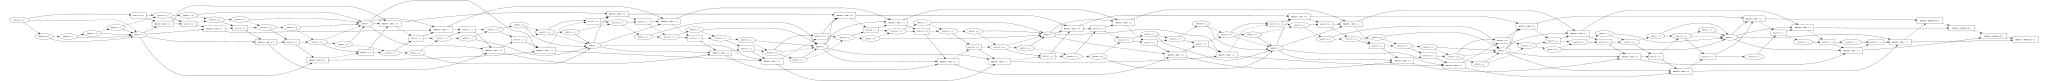

In [37]:
cg = build_block_computation_graph(m)
gv_of_computation_graph(cg)

In [38]:
simulation = simulate_computation_graph(cg)

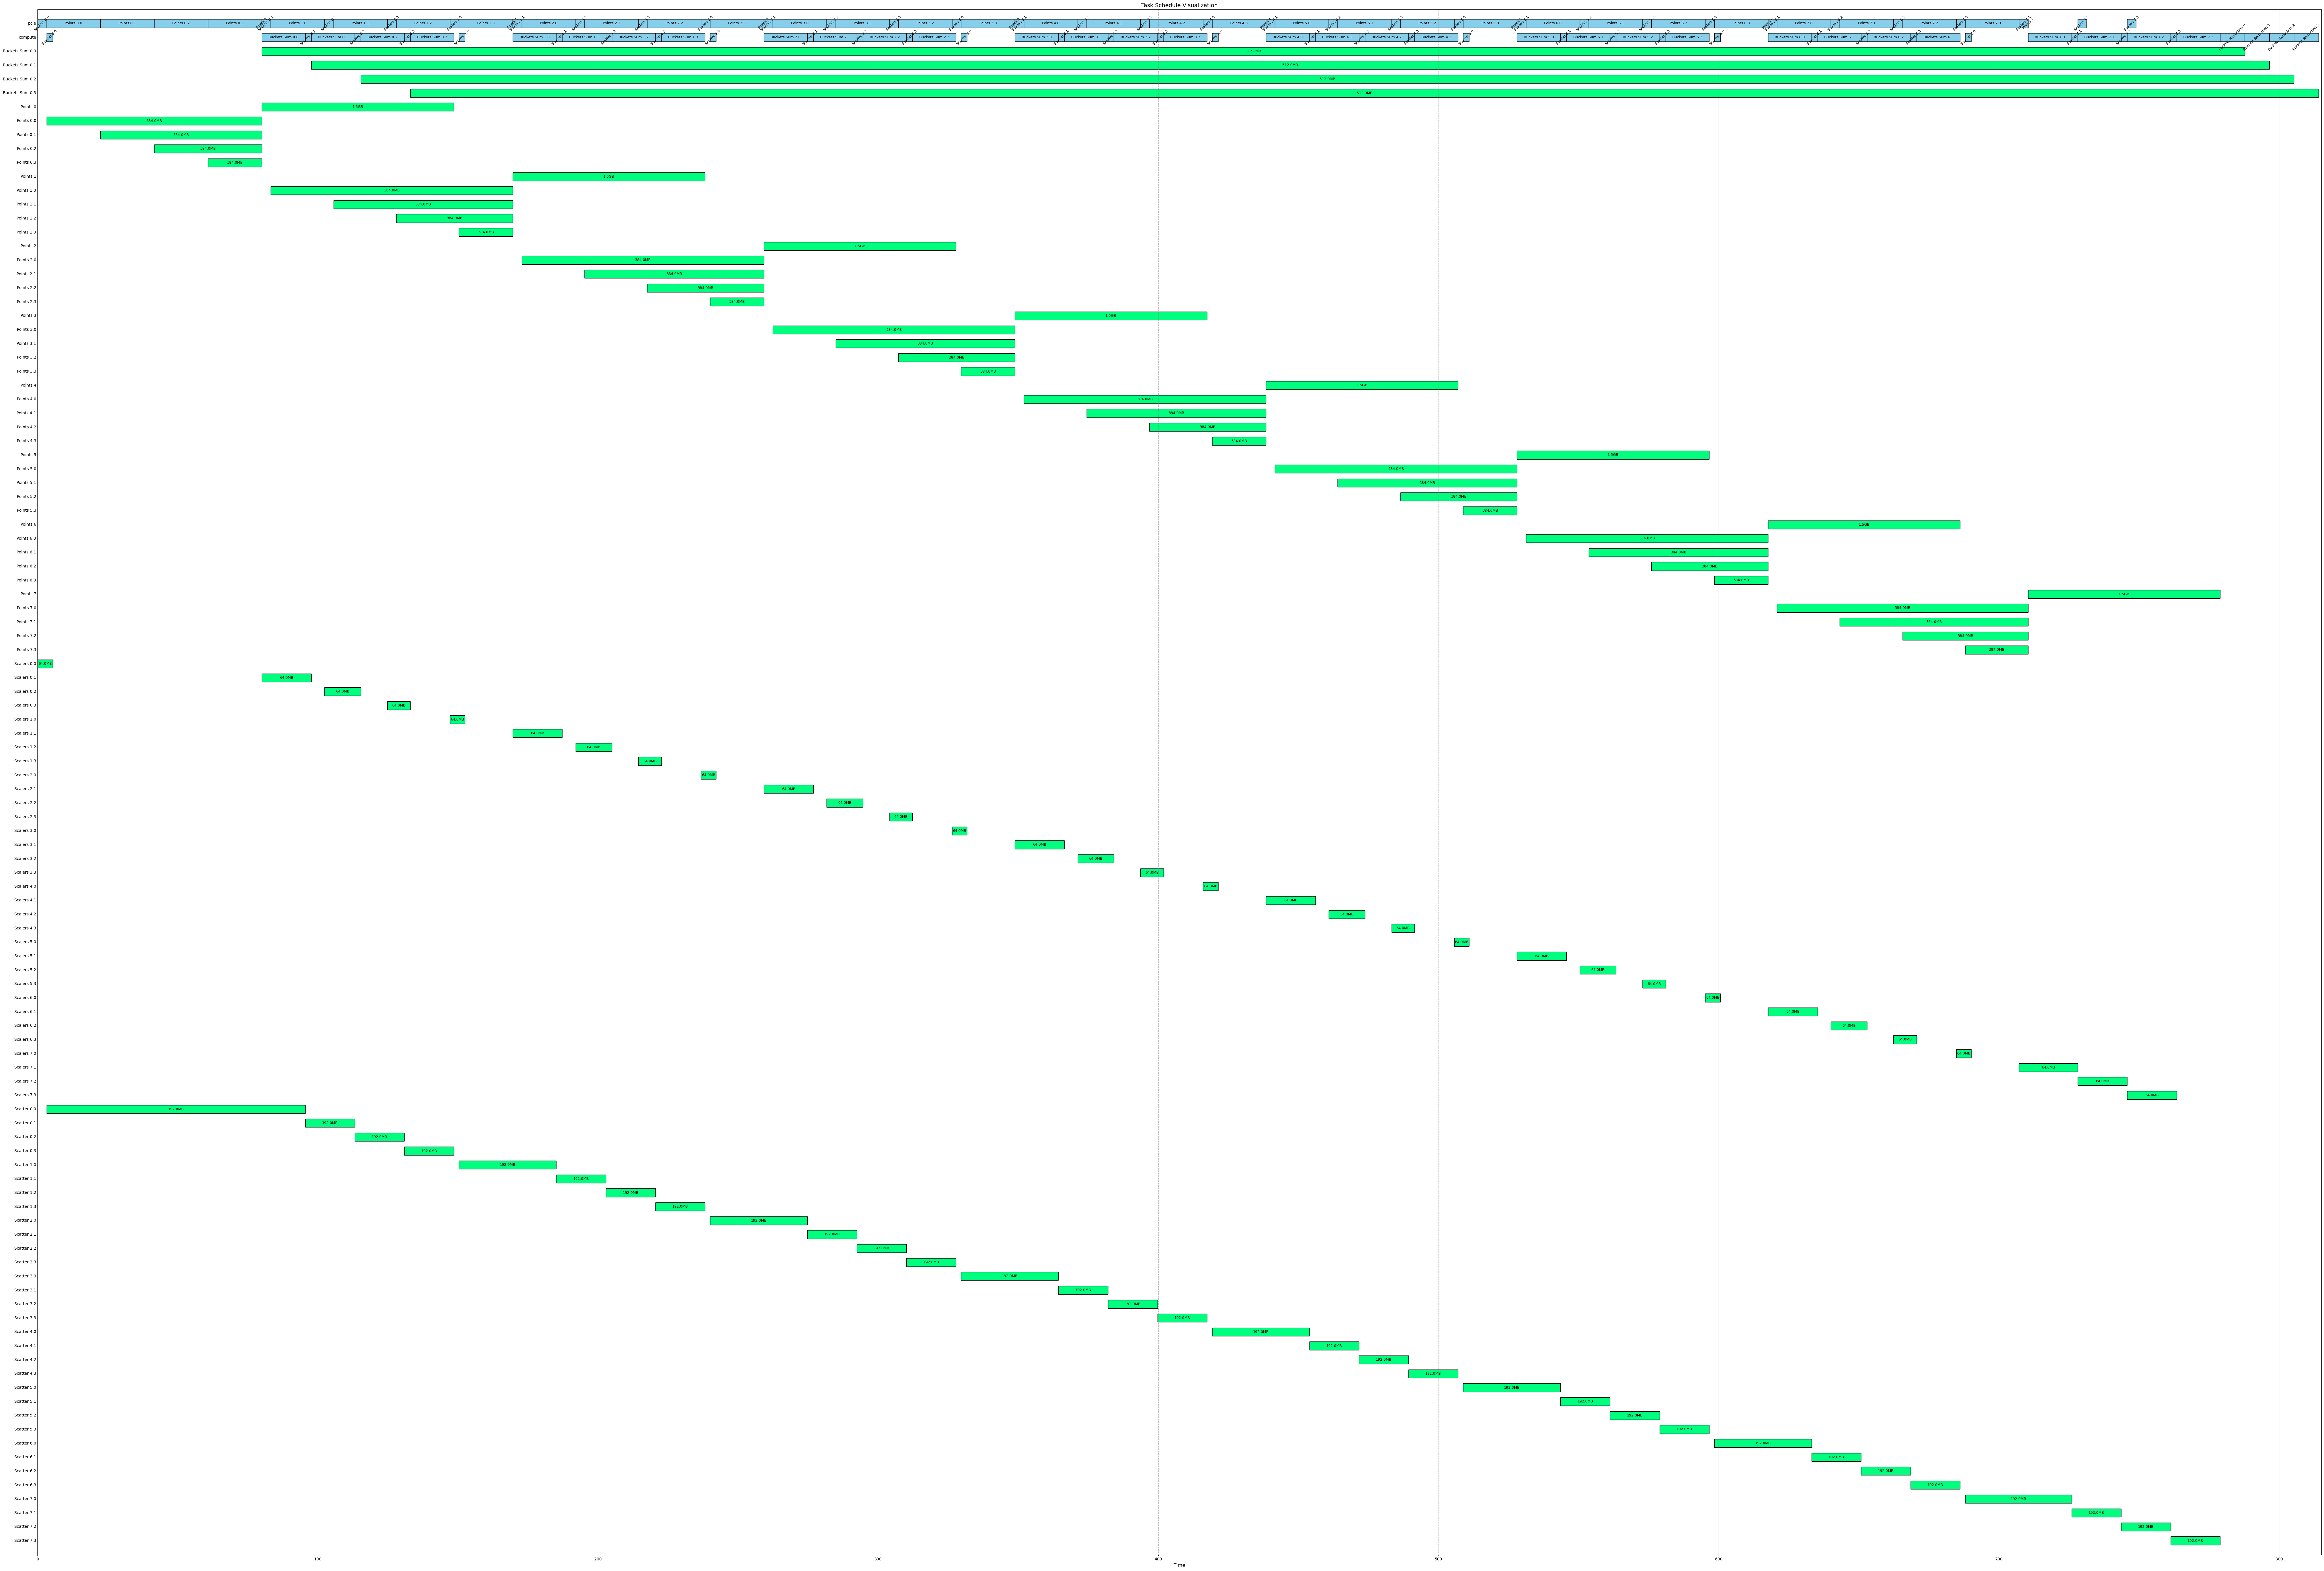

In [39]:
visualize_simulation(simulation, True)

# 策略一

相比增加显存使用，更偏好推迟下一步工作

In [40]:
def t_for_one_block(m: Model, last_col: bool):
    """一个子MSM所需时间，单位毫秒

    Parameters:
        last_col: 这个子MSM是否是批MSM矩阵的最后一个，此后不需要考虑再开始传输下一批标量。
    """
    def prefix_t_for_one_block(m: Model):
        t = 0.0
        t += max(m.t_scalers() + m.t_points(), m.t_scatter())
        t += (m.p.w - 1) * ((m.p.h - 1) * (max(m.t_scalers(), m.t_buckets_sum()) + m.t_scatter()) + m.t_buckets_sum() + max(m.t_scalers() + max(m.t_points(), m.t_scatter()), m.t_scatter()))
        t += (m.p.h - 1) * (max(m.t_scalers(), m.t_buckets_sum()) + m.t_scatter()) + m.t_buckets_sum()
        return t
        
    t = prefix_t_for_one_block(m)
    if last_col:
        t += m.p.h * m.t_buckets_reduction()
    else:
        t += max(m.t_scalers() + max(m.t_points(), m.t_scatter()), m.p.h * m.t_buckets_reduction() + m.t_scatter())
    return t

def total_time(m: Model) -> float:
    """整个批MSM所需时间，单位毫秒"""
    n_rows = division_ceil(m.i.n, m.p.h)
    n_cols = division_ceil(2 ** m.i.k, m.p.w * m.p.c)

    if n_cols == 1:
        return t_for_one_block(m, False) * n_rows
    else:
        return t_for_one_block(m, False) * (n_cols * n_rows - 1) + t_for_one_block(m, True)

def memory(m: Model) -> float:
    """整个批MSM的峰值显存占用，单位字节"""
    return m.s_points() + m.s_scalers() + m.s_indices() + m.p.h * m.s_buckets()

def constrain(m: Model) -> bool:
    return memory(m) <= m.i.g

In [41]:
print(f"One Block takes {t_for_one_block(m, False)}, Total time is {total_time(m)}")

One Block takes 1268.4691689190995, Total time is 1268.4691689190995


In [42]:
memory(m)

4026531840